In [1]:
import pandas as pd
import numpy as np
import topmed_genotypes as tg
import matplotlib.pyplot as plt
import seaborn as sns
from plutils import figures
import tempfile
import subprocess

USE_CLUMPED = False # TODO: if use clumped, should also adjust slope if that's relevant

PREFIX = 'replication-of-direct-trans-eqtl.'

def distance_between_variants(variant_1, variant_2):
    if pd.isnull(variant_1) or pd.isnull(variant_2):
        return np.NaN
    variant_1_chrom, variant_1_pos = variant_1.split('_')[:2]
    variant_2_chrom, variant_2_pos = variant_2.split('_')[:2]
    if variant_1_chrom != variant_2_chrom:
        return np.NaN
    else:
        return abs(int(variant_1_pos) - int(variant_2_pos))


def pi0est(pv):
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        TMP_FILE = f.name
        for p in pv:
            f.write(f'{p}\n')
        f.close()
        cmd = ['Rscript', '-e', f'library(qvalue); tmp = read.table("{TMP_FILE}", head=F)$V1; pi0est(tmp)$pi0']
        sp = subprocess.run(cmd, capture_output=True, check=True)
    return float(sp.stdout.decode().replace('[1] ', '').rstrip())

def pi1est(pv):
    return 1 - pi0est(pv)

DIRECT_TRANS_SIGNIFICANT = '/net/topmed11/working/porchard/direct-preprocessing/work/lift-and-tabix/trans-significant/results/tabixed/direct.txt.gz'
direct_significant = pd.read_csv(DIRECT_TRANS_SIGNIFICANT, sep='\t')
direct_significant.GeneID = direct_significant.GeneID.str.split('.', expand=True)[0]
direct_significant.head()

,#chrom,start,end,GeneID,Phenotype,SNPid,MAF,Nominal_Pval,Coeff,AdjustedPval,DiscoveryOrder
0,chr1,3385156,3385157,ENSG00000070214,ENSG00000070214.11_1:3301721:C:T,chr1_3385157_C_T,0.291074,1.895870e-07,0.094479,0.000100,1
1,chr1,5621884,5621885,ENSG00000100918,ENSG00000100918.8_1:5681945:T:C,chr1_5621885_T_C,0.079922,9.364450e-14,-0.134795,0.000006,1
2,chr1,5621884,5621885,ENSG00000232117,ENSG00000232117.1_1:5681945:T:C,chr1_5621885_T_C,0.079922,5.273810e-09,-0.105826,0.008501,1
3,chr1,14539167,14539168,ENSG00000108798,ENSG00000108798.4_1:14865664:G:C,chr1_14539168_G_C,0.193130,6.470570e-09,-0.105210,0.010294,1
4,chr1,14743606,14743607,ENSG00000196083,ENSG00000196083.5_1:15070103:C:T,chr1_14743607_C_T,0.030874,1.289450e-08,-0.103107,0.007099,1


In [2]:
replicated_in_topmed = pd.read_csv('../work/replicate-trans/direct/results/replicated/results.txt', sep='\t')
print(len(replicated_in_topmed))
replicated_in_topmed = replicated_in_topmed.rename(columns={'slope': 'topmed_slope', 'p': 'topmed_p'}).merge(direct_significant[['GeneID', 'SNPid', 'Nominal_Pval', 'Coeff', 'DiscoveryOrder']].rename(columns={'GeneID': 'gene_id', 'SNPid': 'variant_id'}))
print(len(replicated_in_topmed))
replicated_in_topmed.head()

1860
1860


,variant_id,gene_id,topmed_slope,topmed_p,Nominal_Pval,Coeff,DiscoveryOrder
0,chr1_3385157_C_T,ENSG00000070214,-0.020787,0.328331,1.895870e-07,0.094479,1
1,chr1_5621885_T_C,ENSG00000100918,-0.003761,0.945841,9.364450e-14,-0.134795,1
2,chr1_14539168_G_C,ENSG00000108798,-0.021398,0.319433,6.470570e-09,-0.105210,1
3,chr1_14743607_C_T,ENSG00000196083,0.016127,0.741841,1.289450e-08,-0.103107,1
4,chr1_19935537_A_G,ENSG00000114455,-0.038926,0.394466,1.126560e-08,-0.103522,1


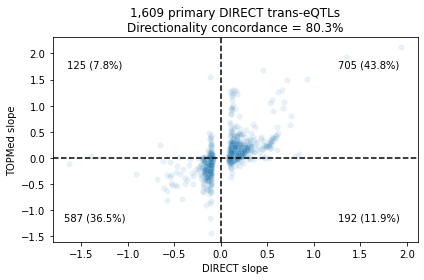

In [3]:
fig, ax = plt.subplots()

df = replicated_in_topmed[replicated_in_topmed.DiscoveryOrder==1]
#df = replicated_in_topmed
ql = figures.make_quadrant_labels(df.Coeff, df.topmed_slope)
sns.scatterplot(x='Coeff', y='topmed_slope', ax=ax, data=df, alpha=0.1)
figures.plot_quadrant_labels(ql, ax)
ax.axvline(0, ls='--', color='black')
ax.axhline(0, ls='--', color='black')
ax.set_xlabel('DIRECT slope')
ax.set_ylabel('TOPMed slope')
ax.set_title('{:,} primary DIRECT trans-eQTLs\nDirectionality concordance = {}%'.format(len(df), round(100*(np.sign(df.Coeff) == np.sign(df.topmed_slope)).mean(), 1)))

fig.tight_layout()
fig.savefig(f'{PREFIX}replication-in-topmed.png', dpi=300, facecolor='white', bbox_inches='tight')

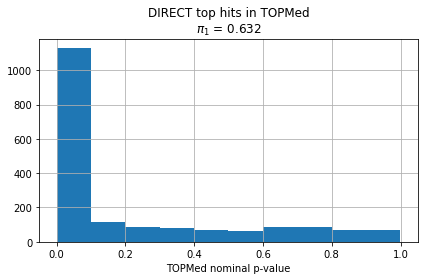

In [4]:
fig, ax = plt.subplots()

replicated_in_topmed.topmed_p.hist(ax=ax)
ax.set_title('DIRECT top hits in TOPMed\n$\pi_1$ = {}'.format(round(pi1est(replicated_in_topmed.topmed_p.to_list()), 3)))
ax.set_xlabel('TOPMed nominal p-value')

fig.tight_layout()
fig.savefig(f'{PREFIX}replication-in-topmed.pi1.png', dpi=300, facecolor='white', bbox_inches='tight')


In [5]:
# using those with same direction of effect
# fig, ax = plt.subplots()

# replicated_in_topmed[np.sign(replicated_in_topmed.topmed_slope)==np.sign(replicated_in_topmed.Coeff)].topmed_p.hist(ax=ax)
# ax.set_title('DIRECT top hits in TOPMed\n$\pi_1$ = {}'.format(round(pi1est(replicated_in_topmed[np.sign(replicated_in_topmed.topmed_slope)==np.sign(replicated_in_topmed.Coeff)].topmed_p.to_list()), 3)))
# ax.set_xlabel('TOPMed nominal p-value')

# fig.tight_layout()

In [6]:
replicated_in_topmed.head()

,variant_id,gene_id,topmed_slope,topmed_p,Nominal_Pval,Coeff,DiscoveryOrder
0,chr1_3385157_C_T,ENSG00000070214,-0.020787,0.328331,1.895870e-07,0.094479,1
1,chr1_5621885_T_C,ENSG00000100918,-0.003761,0.945841,9.364450e-14,-0.134795,1
2,chr1_14539168_G_C,ENSG00000108798,-0.021398,0.319433,6.470570e-09,-0.105210,1
3,chr1_14743607_C_T,ENSG00000196083,0.016127,0.741841,1.289450e-08,-0.103107,1
4,chr1_19935537_A_G,ENSG00000114455,-0.038926,0.394466,1.126560e-08,-0.103522,1


In [7]:
DIRECT_TRANS_LOOSE = '/net/topmed11/working/porchard/direct-preprocessing/work/lift-and-tabix/trans-10e4/results/tabixed/direct.txt.gz'
direct_loose = pd.read_csv(DIRECT_TRANS_LOOSE, sep='\t')
direct_loose.GeneID = direct_loose.GeneID.str.split('.', expand=True)[0]
direct_loose.head()

,#chrom,start,end,GeneID,SNPid,MAF,Pvalue,Slope,SE,AdjustedPvalue
0,chr1,47158,47159,ENSG00000196754,chr1_47159_T_C,0.036466,0.000002,-0.085611,0.211527,0.959949
1,chr1,99686,99687,ENSG00000222046,chr1_99687_C_T,0.017912,0.000004,0.084086,0.215393,0.991436
2,chr1,630025,630026,ENSG00000204291,chr1_630026_C_T,0.449187,0.000003,-0.084288,0.214872,0.989094
3,chr1,632875,632876,ENSG00000165355,chr1_632876_C_T,0.102954,0.000005,0.083139,0.217862,0.997663
4,chr1,713811,713812,ENSG00000186395,chr1_713812_A_T,0.067313,0.000001,-0.087308,0.207387,0.872839


In [8]:
direct_significant[direct_significant.DiscoveryOrder==1].SNPid.isin(direct_loose.SNPid).value_counts()

True     1882
False     109
Name: SNPid, dtype: int64

In [9]:
direct_loose.GeneID.nunique()

14713

In [10]:
direct_loose.describe()

,start,end,MAF,Pvalue,Slope,SE,AdjustedPvalue
count,7.526080e+05,7.526080e+05,752608.000000,7.526080e+05,752608.000000,752608.000000,752608.000000
mean,7.686833e+07,7.686833e+07,0.192881,4.733132e-06,-0.005358,0.212310,0.860860
std,5.516549e+07,5.516549e+07,0.150716,3.332227e-06,0.086911,0.018007,0.279466
min,1.486200e+04,1.486300e+04,0.009762,6.944380e-139,-0.433298,0.037807,0.000003
25%,3.260625e+07,3.260625e+07,0.051290,1.733515e-06,-0.083621,0.208695,0.908083
50%,6.482696e+07,6.482696e+07,0.160645,4.495565e-06,-0.080047,0.217609,0.997463
75%,1.106296e+08,1.106296e+08,0.318900,7.455140e-06,0.082841,0.222813,0.999920
max,2.489068e+08,2.489068e+08,0.500000,1.145150e-05,0.408041,0.227525,0.999997


In [11]:
topmed_trans_eqtl = pd.read_csv('../work/clump-trans-variants/clump-trans-signals.significant-trans-eqtl-clumped.tsv', sep='\t')
if USE_CLUMPED:
    topmed_trans_eqtl.variant_id = topmed_trans_eqtl.clumped_variant_id
topmed_trans_eqtl = topmed_trans_eqtl[topmed_trans_eqtl.tissue=='Whole_blood']
topmed_trans_eqtl['gene_id'] = topmed_trans_eqtl.phenotype_id.str.split('.', expand=True)[0]
topmed_trans_eqtl.head()

,variant_id,phenotype_id,pval,b,b_se,r2,af,gene_mappability,gene_crossmaps_to_gene_near_variant,biotype,...,beta_shape2,true_df,pval_true_df,pval_perm,pval_beta,pval_beta_no_zero,qvalue,tissue,clumped_variant_id,gene_id
0,chr7_50330658_C_T,ENSG00000000938.13,3.503050e-25,-0.234596,0.022533,0.016690,0.235203,0.999762,False,protein_coding,...,9.795177e+05,6086.276059,4.468785e-24,0.00005,3.457262e-18,3.457262e-18,1.392881e-16,Whole_blood,chr7_50342615_A_G,ENSG00000000938
1,chr1_156302480_C_T,ENSG00000002330.13,1.027770e-13,0.134956,0.018106,0.008625,0.500775,0.999556,False,protein_coding,...,1.008630e+06,6081.962583,3.926652e-13,0.00005,3.664337e-07,3.664337e-07,5.779733e-06,Whole_blood,chr1_156344836_A_G,ENSG00000002330
2,chr6_144036619_C_A,ENSG00000004059.11,1.984040e-17,0.331091,0.038865,0.011237,0.055934,1.000000,False,protein_coding,...,9.587406e+05,6060.399614,1.281332e-16,0.00005,9.188711e-11,9.188711e-11,2.100000e-09,Whole_blood,chr6_144036619_C_A,ENSG00000004059
3,chr6_122440739_T_C,ENSG00000004478.8,1.034670e-10,0.126184,0.019495,0.006518,0.706539,0.960425,False,protein_coding,...,1.105596e+06,6130.610651,2.431723e-10,0.00025,2.609707e-04,2.609707e-04,2.773133e-03,Whole_blood,chr6_122440739_T_C,ENSG00000004478
4,chr22_46290431_C_G,ENSG00000004799.8,7.740950e-13,0.207077,0.028839,0.008009,0.107530,1.000000,False,protein_coding,...,9.587406e+05,6060.399614,2.939505e-12,0.00005,2.389651e-06,2.389651e-06,3.403684e-05,Whole_blood,chr22_46290431_C_G,ENSG00000004799


True     1476
False     249
Name: direct_slope, dtype: int64


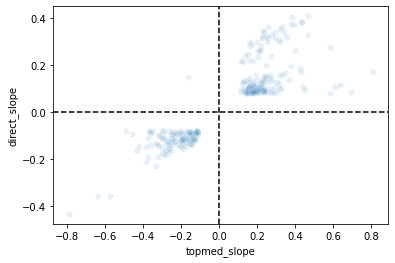

In [12]:
# check directional concordance w/ loose
loose_concordance = topmed_trans_eqtl[['variant_id', 'gene_id', 'b']].rename(columns={'b': 'topmed_slope'}).merge(direct_loose[['GeneID', 'SNPid', 'Slope']].rename(columns={'Slope': 'direct_slope', 'GeneID': 'gene_id', 'SNPid': 'variant_id'}), how='left')
print(loose_concordance.direct_slope.isnull().value_counts())

fig, ax = plt.subplots()

sns.scatterplot(x='topmed_slope', y='direct_slope', ax=ax, data=loose_concordance, alpha=0.1)
ax.axvline(0, color='black', ls='--')
ax.axhline(0, color='black', ls='--')

In [13]:
all_variants = set(topmed_trans_eqtl.variant_id).union(set(direct_significant.SNPid))
all_variants_df = pd.DataFrame(list(all_variants), columns=['variant_id'])
all_variants_df[['chrom', 'pos']] = all_variants_df.variant_id.str.split('_', expand=True)[[0, 1]]
all_variants_df = all_variants_df[~all_variants_df.variant_id.str.contains('GL')]
print(len(all_variants_df))

2088


In [14]:
all_variants_df.chrom.unique()

array(['chr7', 'chr1', 'chr2', 'chr3', 'chr12', 'chr13', 'chr11', 'chr18',
       'chr6', 'chr19', 'chr16', 'chr5', 'chr15', 'chr9', 'chr10',
       'chr14', 'chr17', 'chr4', 'chr8', 'chrX', 'chr20', 'chr22',
       'chr21'], dtype=object)

In [15]:
topmed_whole_blood_samples = pd.read_csv('../data/tensorqtl-in/joint/cis-eqtl/Whole_blood.tensorqtl-in.phenotypes.bed.gz', nrows=1, sep='\t')
topmed_whole_blood_samples = topmed_whole_blood_samples.columns.to_list()[4:]
print(len(topmed_whole_blood_samples))

6454


In [16]:
# TODO: use EUR samples only?
aac = pd.concat(
    [tg.get_alt_allele_counts(vcf_path=f'../data/genotypes/vcfs-updated-ids-pass-filter/{chrom}.vcf.gz', variants=df.variant_id.unique(), samples=topmed_whole_blood_samples) for chrom, df in all_variants_df.groupby('chrom')]
)
aac.head()

,NWD100109,NWD100234,NWD100395,NWD100423,NWD100677,NWD100822,NWD100934,NWD100980,NWD101503,NWD101776,...,NWD998944,NWD999037,NWD999139,NWD999190,NWD999225,NWD999266,NWD999349,NWD999373,NWD999589,NWD999620
chr1_92088726_G_A,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1_156344836_A_G,1,2,1,2,1,1,2,1,2,1,...,2,0,2,1,1,0,0,0,0,1
chr1_181672576_A_G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
chr1_24935531_C_A,1,2,1,1,2,0,2,2,0,0,...,1,1,0,1,2,0,1,2,1,0
chr1_178070091_T_C,0,1,1,1,1,1,1,0,0,1,...,1,0,1,1,1,1,1,0,2,0


In [17]:
ld_matrix = tg.alt_allele_counts_matrix_to_r2_matrix(aac)
ld_matrix.head()

,chr1_92088726_G_A,chr1_156344836_A_G,chr1_181672576_A_G,chr1_24935531_C_A,chr1_178070091_T_C,chr1_5621885_T_C,chr1_158846553_C_T,chr1_94557440_A_G,chr1_158840522_C_T,chr1_153365467_G_A,...,chrX_36811193_CA_C,chrX_66936895_C_T,chrX_53203852_G_C,chrX_95798706_C_T,chrX_53192077_T_TG,chrX_135297239_T_C,chrX_111054598_T_A,chrX_103811887_T_C,chrX_40985535_C_A,chrX_152890172_A_G
chr1_92088726_G_A,1.000000,0.000286,0.000388,0.000670,0.000862,0.000293,0.000812,0.000013,0.000805,0.000371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1_156344836_A_G,0.000286,1.000000,0.000022,0.018894,0.001401,0.002277,0.003654,0.006125,0.004938,0.001423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1_181672576_A_G,0.000388,0.000022,1.000000,0.001472,0.000002,0.000015,0.000280,0.000114,0.000074,0.000001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1_24935531_C_A,0.000670,0.018894,0.001472,1.000000,0.002940,0.004664,0.007600,0.004084,0.003843,0.005945,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1_178070091_T_C,0.000862,0.001401,0.000002,0.002940,1.000000,0.001723,0.002347,0.000146,0.001470,0.000059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# oof -- not even great overlap between trans-eGenes.
topmed_trans_eqtl.gene_id.isin(direct_significant.GeneID).value_counts()

False    1261
True      464
Name: gene_id, dtype: int64

In [19]:
pd.Series(direct_significant.GeneID.unique()).isin(topmed_trans_eqtl.gene_id).value_counts()

False    1206
True      464
dtype: int64

In [20]:
eqtlgen_significant = pd.read_csv('/net/topmed11/working/porchard/eqtlgen-preprocessing/data/eqtlgen/2018-09-04-trans-eQTLsFDR0.05-CohortInfoRemoved-BonferroniAdded.txt.gz', sep='\t')
eqtlgen_transegenes = set(eqtlgen_significant.Gene)

In [21]:
print(topmed_trans_eqtl.gene_id.isin(eqtlgen_transegenes).mean())
topmed_trans_eqtl.gene_id.isin(eqtlgen_transegenes).value_counts()

0.7814492753623189


True     1348
False     377
Name: gene_id, dtype: int64

In [22]:
print(pd.Series(direct_significant.GeneID.unique()).isin(eqtlgen_transegenes).mean())
pd.Series(direct_significant.GeneID.unique()).isin(eqtlgen_transegenes).value_counts()

0.5796407185628742


True     968
False    702
dtype: int64

In [23]:
direct_significant.GeneID.nunique()

1670

In [24]:
direct_transegenes = set(direct_significant.GeneID)
topmed_transegenes = set(topmed_trans_eqtl.gene_id)
transegenes = pd.DataFrame([[i, 'direct'] for i in direct_transegenes] + [[i, 'topmed'] for i in topmed_transegenes] + [[i, 'eqtlgen'] for i in eqtlgen_transegenes], columns=['gene', 'src'])
print(transegenes[transegenes.src=='direct'].gene.isin(transegenes[transegenes.src=='eqtlgen'].gene).mean())
print(transegenes[transegenes.src=='topmed'].gene.isin(transegenes[transegenes.src=='eqtlgen'].gene).mean())
print(transegenes[transegenes.src=='topmed'].gene.isin(transegenes[transegenes.src=='direct'].gene).mean())

0.5796407185628742
0.7814492753623189
0.2689855072463768


In [25]:
significant_concordance = topmed_trans_eqtl[['variant_id', 'gene_id', 'b']].rename(columns={'b': 'topmed_slope', 'variant_id': 'topmed_variant_id'}).merge(direct_significant[['GeneID', 'SNPid', 'Coeff']].rename(columns={'Slope': 'direct_slope', 'GeneID': 'gene_id', 'SNPid': 'direct_variant_id'}))

significant_concordance['same_lead_variant'] = significant_concordance.topmed_variant_id == significant_concordance.direct_variant_id
#significant_concordance['same_lead_variant_and_significant'] = (significant_concordance.same_lead_variant) & (significant_concordance.FDR<=0.05)
significant_concordance['linear_distance'] = [distance_between_variants(i, j) for i, j in zip(significant_concordance.topmed_variant_id, significant_concordance.direct_variant_id)]
significant_concordance['r2'] = [ld_matrix.at[i,j] if i in ld_matrix.index and j in ld_matrix.columns else np.nan for i, j in zip(significant_concordance.topmed_variant_id, significant_concordance.direct_variant_id)]
significant_concordance['high_ld'] = (significant_concordance.r2>=0.8).astype(int)
significant_concordance.head()

,topmed_variant_id,gene_id,topmed_slope,direct_variant_id,Coeff,same_lead_variant,linear_distance,r2,high_ld
0,chr3_56815721_T_C,ENSG00000005249,0.359230,chr11_196944_C_T,0.113967,False,NaN,0.000000,0
1,chr3_56815721_T_C,ENSG00000005249,0.359230,chr3_56815721_T_C,0.318094,True,0.0,1.000000,1
2,chr7_50342615_A_G,ENSG00000005302,0.259733,chr7_28684757_G_T,-0.123213,False,21657858.0,0.019975,0
3,chr19_836654_C_T,ENSG00000005381,-0.212631,chr8_60733792_C_CA,-0.107579,False,NaN,0.000000,0
4,chr19_836654_C_T,ENSG00000005381,-0.212631,chr9_128751091_A_G,0.109331,False,NaN,0.000000,0


In [26]:
print(len(significant_concordance))

774


In [27]:
significant_concordance = significant_concordance[['gene_id', 'same_lead_variant', 'high_ld']].groupby('gene_id').max().reset_index()
significant_concordance.same_lead_variant.value_counts()

False    380
True      84
Name: same_lead_variant, dtype: int64

In [28]:
significant_concordance.high_ld.value_counts()

0    294
1    170
Name: high_ld, dtype: int64

In [29]:
significant_concordance.high_ld.sum() / len(significant_concordance)

0.36637931034482757